In [23]:
# pred = eval_model.predict(X_test, y_test, verbose=0)

In [24]:
# X_test.shape

In [25]:
# y_test.shape

In [2]:
import nest_asyncio
nest_asyncio.apply()
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tqdm import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
import collections
import numpy as np
from tensorflow import reshape, nest, config
from tensorflow.keras import losses, metrics, optimizers
import tensorflow_federated as tff
from matplotlib import pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import reshape, nest, config
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Data Loading and Pre-Processing

In [3]:
experiment_name = "xray_image_dataset"
method = "tff_training"
this_dir = Path.cwd()
model_dir = this_dir / "models" 
output_dir = this_dir / "results" 

data = pd.read_csv("./../texted_data.csv")
label = data["result"]
X = data.drop(["result", "Unnamed: 0"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    label, 
                                                    test_size=0.1, 
                                                    random_state=42)
X_test = X_test.astype(np.float32).values
y_test =  y_test.astype(np.int32).values
X_train = X_train.astype(np.float32).values
y_train =  y_train.astype(np.int32).values

# Creating Federations

In [41]:
split=4 #Number of clients
total_image_count = len(X_train)
image_per_set = int(np.floor(total_image_count/split))



client_train_dataset = collections.OrderedDict()
for i in range(1, split+1):
    client_name = "client_" + str(i)
    start = image_per_set * (i-1)
    end = image_per_set * i

    print(f"Adding data from {start} to {end} for client : {client_name}")
    data = collections.OrderedDict((('label', y_train[start:end]), ('pixels', X_train[start:end])))
    client_train_dataset[client_name] = data



NUM_EPOCHS=10
BATCH_SIZE=10
PREFETCH_BUFFER = 10



train_dataset = tff.simulation.FromTensorSlicesClientData(client_train_dataset)

sample_dataset = train_dataset.create_tf_dataset_for_client(train_dataset.client_ids[0])
#print(sample_dataset['pixels'])
sample_element = next(iter(sample_dataset))

SHUFFLE_BUFFER = image_per_set

def preprocess(dataset):

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x=reshape(element['pixels'], [-1, 7]),
            y=reshape(element['label'], [-1, 1]))



    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
        BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)


preprocessed_sample_dataset = preprocess(sample_dataset)
sample_batch = nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))


def make_federated_data(client_data, client_ids):
    return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

federated_train_data = make_federated_data(train_dataset, train_dataset.client_ids)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Adding data from 0 to 41868 for client : client_1
Adding data from 41868 to 83736 for client : client_2
Adding data from 83736 to 125604 for client : client_3
Adding data from 125604 to 167472 for client : client_4
Number of client datasets: 4
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 7)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


# Model 1

In [40]:
np.random.seed(99)
def model1():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(7, )),
        Dense(128, activation='relu'),
#         Dropout(0.3),
        Dense(2, activation='softmax')

    ])
    return model

#         model = Sequential()
#         model.add(Dense(200, input_shape=(shape,)))
#         model.add(Activation("relu"))
#         model.add(Dense(200))
#         model.add(Activation("relu"))
#         model.add(Dense(classes))
#         model.add(Activation("softmax"))


method = "tff_training"
client_lr = 1e-3
server_lr = 1e-3
NUM_ROUNDS = 10


def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.

    keras_model = model1()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_sample_dataset.element_spec,
      loss=losses.SparseCategoricalCrossentropy(),
      metrics=[metrics.SparseCategoricalAccuracy()])


iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: optimizers.Adagrad(learning_rate=client_lr),
    server_optimizer_fn=lambda: optimizers.RMSprop(learning_rate=server_lr))

print(str(iterative_process.initialize.type_signature))

state = iterative_process.initialize()

tff_train_acc1 = []
tff_val_acc1 = []
tff_train_loss1 = []
tff_val_loss1 = []

eval_model1 = None
best_accuracy = 0
for round_num in range(1, NUM_ROUNDS+1):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    eval_model1 = model1()
    eval_model1.compile(optimizer=optimizers.Adam(learning_rate=client_lr),
                       loss=losses.SparseCategoricalCrossentropy(),
                       metrics=[metrics.SparseCategoricalAccuracy()])

    tff.learning.assign_weights_to_keras_model(eval_model1, state.model)

    ev_result1 = eval_model1.evaluate(X_test, y_test, verbose=0)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
    print(f"Validation loss : {ev_result1[0]} and Validation accuracy : {ev_result1[1]}")
    tff_train_acc1.append(float(tff_metrics.sparse_categorical_accuracy))
    tff_val_acc1.append(ev_result1[1])
    tff_train_loss1.append(float(tff_metrics.loss))
    tff_val_loss1.append(ev_result1[0])
    if ev_result1[1] > best_accuracy:
        eval_model1.save_weights('./checkpoints/my_checkpoint')
        best_accuracy = ev_result1[1]
        eval_model1.save("federated_best_texted_model1.h5")

metric_collection = {"sparse_categorical_accuracy": tff_train_acc1,
                     "val_sparse_categorical_accuracy": tff_val_acc1,
                     "loss": tff_train_loss1,
                     "val_loss": tff_val_loss1}



( -> <model=<trainable=<float32[7,64],float32[64],float32[64,128],float32[128],float32[128,2],float32[2]>,non_trainable=<>>,optimizer_state=<int64,float32[7,64],float32[64],float32[64,128],float32[128],float32[128,2],float32[2]>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)
round  1, metrics=<sparse_categorical_accuracy=0.8871763348579407,loss=0.3437453806400299,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.6305394982162889 and Validation accuracy : 0.8711376190185547
round  2, metrics=<sparse_categorical_accuracy=0.888870358467102,loss=0.3399884104728699,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.6134387820364935 and Validation accuracy : 0.8769412636756897
round  3, metrics=<sparse_categorical_accuracy=0.8899750113487244,loss=0.33790481090545654,keras_training_time_client_sum_sec=0.0>
Validation loss : 0.6001946973617448 and Validation accuracy : 0.8811327815055847
round  4, metrics=<sparse_categorical_accuracy=0.8907877206802368,loss=0.336

## Evaluation

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     16176
           1       0.84      0.23      0.36      2433

    accuracy                           0.89     18609
   macro avg       0.87      0.61      0.65     18609
weighted avg       0.89      0.89      0.87     18609



<AxesSubplot:>

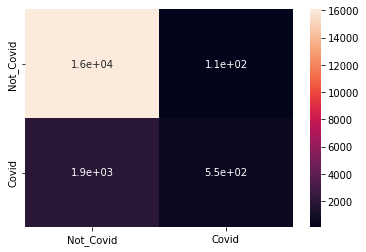

In [4]:
model1 = tf.keras.models.load_model('federated_best_texted_model1.h5')
pred1 = model1.predict(X_test)
pred1 = np.argmax(pred1, axis=-1)
print(classification_report(y_test, pred1))
cm = confusion_matrix(y_test, pred1)
sns.heatmap(cm, annot = True, xticklabels=["Not_Covid", "Covid"], yticklabels=["Not_Covid", "Covid"])

## Plotting Results

In [42]:
def plot_graph(X, y, format = '-', label=''):
    plt.plot(X, y, format, label=label)
    plt.xlabel("Rounds")
    plt.ylabel("Value")
    plt.grid(True)

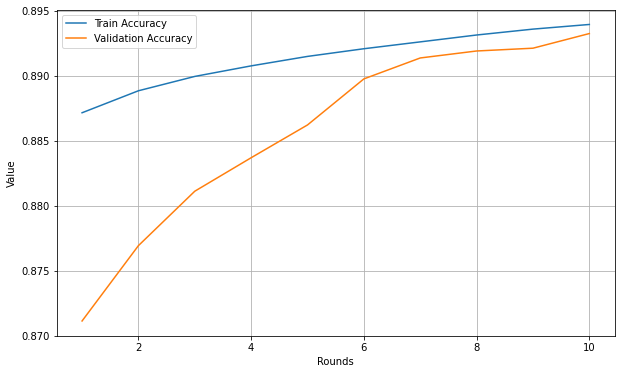

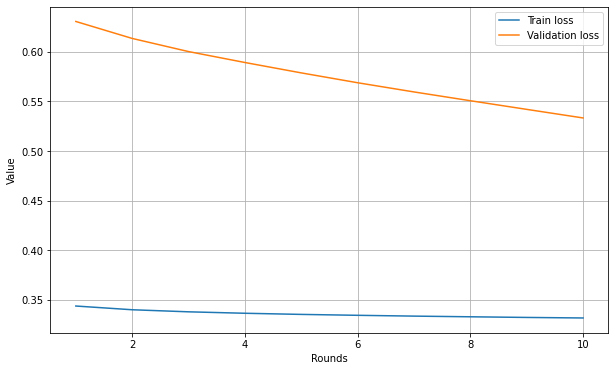

In [48]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_acc1, label='Train Accuracy')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_acc1, label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_texted_model1_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_train_loss1, label='Train loss')
plot_graph(list(range(1, NUM_ROUNDS +1)), tff_val_loss1, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_texted_model1_loss.png")